# Aplicações de Painel

## Importações

In [160]:
## Importando o que for necessário
import pandas as pd
import numpy as np
from scipy import stats
from zipfile import ZipFile
import statsmodels.api as sm
import statsmodels.stats.api as sms
from IPython.display import clear_output # limpa o output de uma célula

In [161]:
## Modelos de painel
! pip install linearmodels  # já atualiza o statsmodels (caso precise)
from linearmodels import PooledOLS, PanelOLS, RandomEffects
from linearmodels.panel import compare

## Para funções com modelos de painel, ver:
# https://bashtage.github.io/linearmodels/panel/introduction.html

In [162]:
## Montando o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [163]:
## Definindo caminho
sCaminho = "/content/drive/Othercomputers/Meu modelo MacBook Air/Documents/IPEA/Curso IDP/Dados/"

##1. Como variou o retorno da educação e da sindicalização nos EUA durante a década de 80?

Os dados compreendem o período de 1980 e 1987 e são um painel composto por 545 homens (não há mulheres) que sempre estiveram empregados (veremos o quão balanceado é mais a frente).

A pergunta aqui é: **como mudou** a influência dos fatores ao longo da década de 1980? Lembre-se que modelos em painel permitem ver a **evolução ao longo do tempo**, mas não ter uma estimativa do efeito total (já que estimativas em cortes transversais simples são viesados pela presença de características não-observáveis).

In [164]:
## Lendo o dataset
# Descrição das variáveis: https://www.rdocumentation.org/packages/wooldridge/versions/1.4-1/topics/wagepan
sArquivo = f"{sCaminho}wagepan.dta"
df = pd.read_stata(sArquivo)

In [165]:
## Visualizando o dataset
df.head(10)

# indivíduo: nr
# tempo: year

,nr,year,agric,black,bus,construc,ent,exper,fin,hisp,poorhlth,hours,manuf,married,min,nrthcen,nrtheast,occ1,occ2,occ3,occ4,occ5,occ6,occ7,occ8,occ9,per,pro,pub,rur,south,educ,tra,trad,union,lwage,d81,d82,d83,d84,d85,d86,d87,expersq
0,13,1980,0,0,1,0,0,1,0,0,0,2672,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,14,0,0,0,1.197540,0,0,0,0,0,0,0,1
1,13,1981,0,0,0,0,0,2,0,0,0,2320,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,14,0,0,1,1.853060,1,0,0,0,0,0,0,4
2,13,1982,0,0,1,0,0,3,0,0,0,2940,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,14,0,0,0,1.344462,0,1,0,0,0,0,0,9
3,13,1983,0,0,1,0,0,4,0,0,0,2960,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,14,0,0,0,1.433213,0,0,1,0,0,0,0,16
4,13,1984,0,0,0,0,0,5,0,0,0,3071,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,14,0,0,0,1.568125,0,0,0,1,0,0,0,25
5,13,1985,0,0,1,0,0,6,0,0,0,2864,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,1.699891,0,0,0,0,1,0,0,36
6,13,1986,0,0,1,0,0,7,0,0,0,2994,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,-0.720263,0,0,0,0,0,1,0,49
7,13,1987,0,0,1,0,0,8,0,0,0,2640,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,1.669188,0,0,0,0,0,0,1,64
8,17,1980,0,0,0,0,0,4,0,0,0,2484,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,13,0,1,0,1.675962,0,0,0,0,0,0,0,16
9,17,1981,0,0,0,0,0,5,0,0,0,2804,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,13,0,1,0,1.518398,1,0,0,0,0,0,0,25


In [166]:
# Vendo o tamanho da base
print(f"Linhas: {df.shape[0]}; Colunas: {df.shape[1]}")

Linhas: 4360; Colunas: 44


In [167]:
## Vendo quais variáveis são constantes ao longo do tempo (variância 0)
# Constantes: 
# agric(dummy se trabalha na agricultura), black e hisp (dummies de cor)
# manuf (dummy se trabalha na manufatura), south, nrthcen e nrtheast (dummies regionais)
# e, mais importante, educação (todos os homens são adultos e apenas trabalham)
df.groupby('nr').var()

,year,agric,black,bus,construc,ent,exper,fin,hisp,poorhlth,hours,manuf,married,min,nrthcen,nrtheast,occ1,occ2,occ3,occ4,occ5,occ6,occ7,occ8,occ9,per,pro,pub,rur,south,educ,tra,trad,union,lwage,d81,d82,d83,d84,d85,d86,d87,expersq
nr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13,6.0,0.0,0.0,0.214286,0.000000,0.000,6.0,0.000000,0.0,0.0,61755.982143,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.267857,0.000000,0.000000,0.125000,0.000000,0.000000,0.0,0.285714,0.214286,0.000000,0.000,0.000,0.0,0.0,0.000000,0.000000,0.125000,0.681418,0.125,0.125,0.125,0.125,0.125,0.125,0.125,510.0
17,6.0,0.0,0.0,0.000000,0.267857,0.000,6.0,0.000000,0.0,0.0,42100.696429,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.267857,0.000000,0.000000,0.125000,0.000000,0.214286,0.0,0.000000,0.000000,0.000000,0.000,0.000,0.0,0.0,0.000000,0.267857,0.000000,0.009753,0.125,0.125,0.125,0.125,0.125,0.125,0.125,1374.0
18,6.0,0.0,0.0,0.000000,0.000000,0.000,6.0,0.000000,0.0,0.0,13342.571429,0.125000,0.000000,0.0,0.0,0.0,0.000000,0.125000,0.267857,0.214286,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000,0.0,0.0,0.000000,0.125000,0.000000,0.186106,0.125,0.125,0.125,0.125,0.125,0.125,0.125,1374.0
45,6.0,0.0,0.0,0.125000,0.125000,0.000,6.0,0.000000,0.0,0.0,112860.982143,0.267857,0.125000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.214286,0.000000,0.267857,0.125000,0.0,0.000000,0.000000,0.000000,0.000,0.000,0.0,0.0,0.267857,0.000000,0.214286,0.049972,0.125,0.125,0.125,0.125,0.125,0.125,0.125,750.0
110,6.0,0.0,0.0,0.125000,0.000000,0.000,6.0,0.214286,0.0,0.0,90266.000000,0.000000,0.285714,0.0,0.0,0.0,0.214286,0.214286,0.000000,0.285714,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.285714,0.000,0.000,0.0,0.0,0.000000,0.125000,0.125000,0.009836,0.125,0.125,0.125,0.125,0.125,0.125,0.125,1758.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12451,6.0,0.0,0.0,0.000000,0.000000,0.125,6.0,0.000000,0.0,0.0,127316.214286,0.125000,0.267857,0.0,0.0,0.0,0.214286,0.000000,0.000000,0.000000,0.000000,0.125000,0.125000,0.0,0.000000,0.000000,0.214286,0.000,0.125,0.0,0.0,0.000000,0.000000,0.000000,0.137637,0.125,0.125,0.125,0.125,0.125,0.125,0.125,750.0
12477,6.0,0.0,0.0,0.000000,0.000000,0.000,6.0,0.000000,0.0,0.0,12800.000000,0.000000,0.214286,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.267857,0.285714,0.000000,0.0,0.125000,0.000000,0.000000,0.000,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.001519,0.125,0.125,0.125,0.125,0.125,0.125,0.125,1374.0
12500,6.0,0.0,0.0,0.267857,0.000000,0.000,6.0,0.000000,0.0,0.0,248767.428571,0.125000,0.214286,0.0,0.0,0.0,0.000000,0.125000,0.000000,0.000000,0.267857,0.000000,0.000000,0.0,0.214286,0.000000,0.000000,0.000,0.000,0.0,0.0,0.000000,0.285714,0.000000,0.198548,0.125,0.125,0.125,0.125,0.125,0.125,0.125,1374.0


### Montando a estrutura de painel

In [168]:
## Vendo grau de balancemaneto/desbalanceamento
df['aparicoes'] = df.groupby('nr')['nr'].transform('count')
df.drop_duplicates(subset=['nr'], keep='first')['aparicoes'].value_counts(normalize=True)*100
# O painel é completamente balanceado (muito díficil na vida real, vide PNAD COVID e a PNADC, que costuma ser pior)

8    100.0
Name: aparicoes, dtype: float64

In [169]:
## Montando a estrutura do painel
# drop=false mantém as colunas no DataFrame, o que facilita a inclusão de dummies anuais usando C(year)
df = df.set_index(["nr", "year"], drop=False)

In [170]:
## Vendo o resultado
df.head(10)

nr  year  agric  black  bus  ...  d85  d86  d87  expersq  aparicoes
nr year                               ...                                   
13 1980  13  1980      0      0    1  ...    0    0    0        1          8
   1981  13  1981      0      0    0  ...    0    0    0        4          8
   1982  13  1982      0      0    1  ...    0    0    0        9          8
   1983  13  1983      0      0    1  ...    0    0    0       16          8
   1984  13  1984      0      0    0  ...    0    0    0       25          8
   1985  13  1985      0      0    1  ...    1    0    0       36          8
   1986  13  1986      0      0    1  ...    0    1    0       49          8
   1987  13  1987      0      0    1  ...    0    0    1       64          8
17 1980  17  1980      0      0    0  ...    0    0    0       16          8
   1981  17  1981      0      0    0  ...    0    0    0       25          8

[10 rows x 45 columns]

### Modelos

Uma boa equação de salários para começar a análise de mudança no retorno da educação é 

lsalariohora = married + union + dt*educ

Por que?

- Pessoas casadas tendem a ganhar mais (seja porque se sentem mais motivadas, porque dividem o trabalho doméstico, várias teorias)

- Pessoas sindicalizadas tendem a ganhar mais e ter salários mais "pegajosos" (fenômeno mais particular dos EUA, principalmente antes das reformas dos anos 90)

In [171]:
## Estimando a equação por efeitos fixos
# Operador ':' cria interações entre as variáveis
# Operador '*' cria interações entre as variáveis E as adiciona sozinhas
formula_simples = "lwage ~ 1 + union + married + C(year)*educ + EntityEffects"

# Criando o modelo
# drop_absorbed: se tiver alguma variável constante no tempo, pulá-la
modelo_ef_simples = PanelOLS.from_formula(formula=formula_simples, data=df, drop_absorbed=True)
modelo_ef_simples = modelo_ef_simples.fit(cov_type='robust')

# Printando resultado
print(modelo_ef_simples.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.1708
Estimator:                   PanelOLS   R-squared (Between):              0.0905
No. Observations:                4360   R-squared (Within):               0.1708
Date:                Fri, Oct 22 2021   R-squared (Overall):              0.1277
Time:                        18:53:08   Log-likelihood                   -1350.7
Cov. Estimator:                Robust                                           
                                        F-statistic:                      48.907
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                 F(16,3799)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             43.137
                            

/usr/local/lib/python3.7/dist-packages/linearmodels/panel/model.py:1798: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

educ

  AbsorbingEffectWarning,


A mensagem de erro acima nos diz que educ teve que ser *droppada* da equação, o que se deve a ela ser constante no tempo.

Só parece haver um aumento significante no retorno da educação (frente a 1980) a partir de 1986.
Em 1987, por exemplo, estima-se que o retorno educacional seja 3% maior do que era em 1980, o que pode ser explicado, por exemplo, pela revolução tecnológica e pela preferência a trabalhos mais intelectuais no setor de serviços.

Outra coisa a se notar é que não parece ter havido mudanças estruturais ao longo da década, o que é captado pelas dummies de cada ano (insignificantes individualmente).

In [172]:
## Podemos testar se as variáveis dummies são conjuntamente significantes usando um teste F,
# que pode ser interpretado como uma versão do teste t aplicado a mais de uma variável
H0 = "0 = C(year)[T.1981] = C(year)[T.1982] = C(year)[T.1983] = C(year)[T.1984] = C(year)[T.1985] = C(year)[T.1986] = C(year)[T.1987]"

print(f"O p-valor do teste é {modelo_ef_simples.wald_test(formula=H0).pval}")

# O p-valor é de 0,97, ou seja, não há mudanças estruturais no tempo (as mudanças temporais se devem a mudanças no retorno da educação)

O p-valor do teste é 0.9731301632056536


### Comparando Modelos: Vale a pena ser sindicalizado?

Usaremos três métodos e uma equação mais completa para estimar a equação salarial de **homens**: MQO Agrupado, EF e EA

In [173]:
## Definindo a fórmula
formula = "lwage ~ 1 + educ + black + hisp + exper + expersq + married + union + C(year)"
formula_ef = f"{formula} + EntityEffects"

## Criando os três modelos
# Lembrando: o tipo da covariância não afetas as estimativas centrais, apenas os erros-padrão e os testes t dos estimadores.
# Efeitos Fixos
modelo_ef = PanelOLS.from_formula(formula=formula_ef, data=df, drop_absorbed=True)
modelo_ef = modelo_ef.fit(cov_type='robust')

# Efeitos Aleatórios
modelo_ea = RandomEffects.from_formula(formula=formula, data=df).fit(cov_type='robust')

# OLS Agrupado
modelo_ols = PooledOLS.from_formula(formula=formula, data=df).fit(cov_type='robust')

/usr/local/lib/python3.7/dist-packages/linearmodels/panel/model.py:1798: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

educ, black, hisp, exper

  AbsorbingEffectWarning,


In [174]:
## Vendo os resultados
print("P-valores entre parênteses.")
print(compare(
    {'EF':modelo_ef, 
     'EA':modelo_ea,
     'MQOA':modelo_ols}, 
     precision = 'pvalues').summary)

P-valores entre parênteses.
                             Model Comparison                            
                                     EF                EA            MQOA
-------------------------------------------------------------------------
Dep. Variable                     lwage             lwage           lwage
Estimator                      PanelOLS     RandomEffects       PooledOLS
No. Observations                   4360              4360            4360
Cov. Est.                        Robust            Robust          Robust
R-squared                        0.1806            0.1806          0.1893
R-Squared (Within)               0.1806            0.1799          0.1692
R-Squared (Between)             -0.0052            0.1853          0.2066
R-Squared (Overall)              0.0807            0.1828          0.1893
F-statistic                      83.851            68.409          72.459
P-value (F-stat)                 0.0000            0.0000          0.0000
==========

Antes de iniciar a análise, observa-se que experiência também não é estimada em efeitos fixos.

Como incluímos dummies para todos os anos e todos os homens trabalham em todos os anos (ou seja, *exper* varia sempre em uma unidade), ela não pode ser estimada por EF (o aumento constante de um ano não pode ser distinguído do efeito temporal agregado).
expersq, por sua vez, muda de forma variável ao longo dos anos -- 20^2 - 19^2 é diferente de 21^2 - 20^2.

Quando controlamos para todos os efeitos não-observáveis (EF e EA), o retorno de ser sindicalizado e casado cai (o que indica que homens mais 'capazes' tendem a ser casados e mais sindicalizados).

Essa foi a conclusão de um estudo publicado na [*Journal of Applied Econometrics*](https://www.jstor.org/stable/223257): pessoas sindicalizadas tendem a ter uma heterogeneidade individual que contribui para os salários, o que pode ser visto nos maiores coeficientes de EA e MQOA.

In [175]:
## Teste de Hausman para ver qual modelo é melhor
# Antes, precisamos garantir que EA tenha as MESMAS variáveis que EF,
# ou seja, sem as variáveis constantes no tempo
formula_ea = "lwage ~ 1 + expersq + married + union + C(year)"
modelo_ea = RandomEffects.from_formula(formula=formula_ea, data=df).fit(cov_type='kernel')

In [176]:
## Calculando estatística de Hausman
# Variância Assintótica
var_assin = modelo_ef.cov - modelo_ea.cov

# Diferença entre os parâmetros
dif_parametros = modelo_ef.params - modelo_ea.params

# Calculando a estatística de Hausman
H = dif_parametros.dot(np.linalg.inv(var_assin)).dot(dif_parametros)

# Grau de Liberdade
graus_liberdade = modelo_ea.params.size - 1

# Calculando p-valor
# H0: não há correlação entre as variáveis independentes e as características não-observáveis
# Não-rejeitar H0: prefere-se EA, mas EF ainda é consisteente
# Rejeitar: prefere-se EF e EA é inconsistente
p = stats.chi2(graus_liberdade).sf(H)

print(p)

# As características não-observáveis NÃO são correlacionadas com as variáveis do modelo
# Assim, prefere-se EA 
# Melhor dos mundos: temos um estimador que elimina efeitos não-observados, consistente, eficiente 
# e que consegue estimar variáveis constantes no tempo

0.23567917827305787


### Analisando as mudanças na sindicalização ao longo do tempo por Efeitos Aleatórios

In [178]:
## Se a média de salário de sindicalizados é maior, espera-se que mais pessoas se tornem sindicalizadas
# Isso aconteceu mesmo?
df['year_column'] = df['year']  # criando para evitar um erro de ambiguidade no groupby (index e coluna se chamam year)
df.groupby('year_column')['union'].mean()

## Ao longo de 1980 a 1986, a sindicalização diminuiu ao longo do tempo

year_column
1980    0.251376
1981    0.249541
1982    0.256881
1983    0.245872
1984    0.251376
1985    0.223853
1986    0.211009
1987    0.262385
Name: union, dtype: float64

In [136]:
## Vamos ver se o retorno da sindicalização mudou ao longo do tempo
# Novamente, usamos o operador *
formula_union = "lwage ~ 1 + educ + black + hisp + exper + expersq + married + union*C(year)"

# Criando o modelo
modelo_ea_union = RandomEffects.from_formula(formula=formula_union, data=df)
modelo_ea_union = modelo_ea_union.fit(cov_type='robust')

# Printando modelo_ef_union
print(modelo_ea_union.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  lwage   R-squared:                        0.1825
Estimator:              RandomEffects   R-squared (Between):              0.1854
No. Observations:                4360   R-squared (Within):               0.1821
Date:                Fri, Oct 22 2021   R-squared (Overall):              0.1839
Time:                        18:43:04   Log-likelihood                   -1616.7
Cov. Estimator:                Robust                                           
                                        F-statistic:                      46.119
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                 F(21,4338)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             43.359
                            

Como *union* não é constante no tempo, conseguimos estimá-la para o ano base.
Em 1980, o retorno para o salário de ser sindicalizado era de ≈+17,47%, o que se reduziu principalmente a partir de 1986 (mesmo ano em que a mudança no retorno da educação passa a ser significante no modelo anterior).

## 2. Analisando fatores determinantes de fatalidades no trânsito em diferentes estados dos EUA

O dataset contém informações de 48 estados americanos para os anos de 1980 a 2004, contendo, além da informação de taxas de fatalidade, variáveis que indicam algumas políticas de trânsito de cada estado.

Note que as "características não-observáveis" de cada indivíduo da amostra serão as **particularidades culturais/institucionais** de cada estado (que até podem ser capturadas, mas não estão presentes na nossa base de dados).

In [137]:
## Lendo o dataset
# Descrição das variáveis: https://rdrr.io/cran/wooldridge/man/driving.html
sArquivo = f"{sCaminho}driving.dta"
df = pd.read_stata(sArquivo)

In [138]:
df.head()

,year,state,sl55,sl65,sl70,sl75,slnone,seatbelt,minage,zerotol,gdl,bac10,bac08,perse,totfat,nghtfat,wkndfat,totfatpvm,nghtfatpvm,wkndfatpvm,statepop,totfatrte,nghtfatrte,wkndfatrte,vehicmiles,unem,perc14_24,sl70plus,sbprim,sbsecon,d80,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90,d91,d92,d93,d94,d95,d96,d97,d98,d99,d00,d01,d02,d03,d04,vehicmilespc
0,1980,1,1.0,0.0,0.0,0.0,0.0,0,18.0,0.0,0.0,1.0,0.0,0.0,940,422,236,3.20,1.437,0.803,3893888,24.139999,10.840000,6.06,29.375000,8.8,18.900000,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7543.874023
1,1981,1,1.0,0.0,0.0,0.0,0.0,0,18.0,0.0,0.0,1.0,0.0,0.0,933,434,248,3.35,1.558,0.890,3918520,24.070000,11.080000,6.33,27.851999,10.7,18.700001,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7107.785156
2,1982,1,1.0,0.0,0.0,0.0,0.0,0,18.0,0.0,0.0,1.0,0.0,0.0,839,376,224,2.81,1.259,0.750,3925218,21.370001,9.580000,5.71,29.857651,14.4,18.400000,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7606.622070
3,1983,1,1.0,0.0,0.0,0.0,0.0,0,18.0,0.0,0.0,1.0,0.0,0.0,930,397,223,3.00,1.281,0.719,3934109,23.640001,10.089999,5.67,31.000000,13.7,18.000000,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7879.802246
4,1984,1,1.0,0.0,0.0,0.0,0.0,0,18.0,0.0,0.0,1.0,0.0,0.0,932,421,237,2.83,1.278,0.720,3951834,23.580000,10.650001,6.00,32.932858,11.1,17.600000,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8333.562500


In [139]:
# Vendo o tamanho da base
print(f"Linhas: {df.shape[0]}; Colunas: {df.shape[1]}")

Linhas: 1200; Colunas: 56


In [140]:
## Descrevendo o dataset
df.describe()

# bac08 e bac10: limite máximo de álcool no sangue
# per se: revogação de licença imediatamente após crise de trânsito
# sbprim: oficiais de trânsito podem multar pessoas que não usem cinto de segurança (primary seatbelt law)
# sbsecon: oficiais de trânsito só podem multar a falta de cinto se houver algum outro motivo para parar o carro
# s170plus: limite de velocidade (speed limit) médio acima de 70 milhas por hora
# gdl: programa de supervisão de motoristas mais jovens
# perc14_24: percentagem da população entre 14 e 24 anos
# unem: taxa de desemprego
# vehicmilespc: número de milhas dirigidas por ano

,year,state,sl55,sl65,sl70,sl75,slnone,seatbelt,minage,zerotol,gdl,bac10,bac08,perse,totfat,nghtfat,wkndfat,totfatpvm,nghtfatpvm,wkndfatpvm,statepop,totfatrte,nghtfatrte,wkndfatrte,vehicmiles,unem,perc14_24,sl70plus,sbprim,sbsecon,d80,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90,d91,d92,d93,d94,d95,d96,d97,d98,d99,d00,d01,d02,d03,d04,vehicmilespc
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1.200000e+03,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,1992.000000,27.145833,0.353280,0.439893,0.119015,0.080242,0.007569,1.115833,20.597830,0.451944,0.174100,0.623055,0.213542,0.547083,900.726667,427.282500,222.274167,2.122121,0.999037,0.525541,5.329896e+06,18.918558,8.795606,4.605783,46.323311,5.951250,15.329083,0.206827,0.179167,0.468333,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,9129.039062
std,7.214109,14.386233,0.469843,0.484328,0.319323,0.269109,0.086340,0.898938,0.926856,0.490509,0.374304,0.472200,0.400595,0.492866,879.077363,441.935657,226.461884,0.765226,0.428411,0.240774,5.642165e+06,6.367407,3.283411,1.809453,47.625610,2.074942,1.877211,0.400092,0.383652,0.499204,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,1825.897827
min,1980.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000,26.000000,10.000000,0.780000,0.270000,0.114000,4.534010e+05,6.200000,2.660000,1.180000,3.702700,2.200000,11.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4372.046387
25%,1986.000000,15.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,310.000000,139.750000,70.000000,1.577500,0.684750,0.341000,1.641938e+06,14.377500,6.337500,3.240000,14.573700,4.500000,13.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7788.096436
50%,1992.000000,27.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,21.000000,0.000000,0.000000,1.000000,0.000000,1.000000,676.000000,316.000000,163.000000,2.020000,0.913000,0.477000,3.700425e+06,18.435000,8.420000,4.390000,33.863279,5.600000,14.900001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9012.670410
75%,1998.000000,39.250000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,21.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1099.500000,518.250000,277.000000,2.500000,1.211000,0.642000,6.069563e+06,22.772501,10.650001,5.680000,58.638624,7.000000,16.599998,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

Estamos interessados na variável *totfatrte* (*total fatality rate*): a taxa de fatalidade por 100.000 habitantes.

year
1980    25.494583
1981    23.670208
1982    20.942499
1983    20.152916
1984    20.267500
1985    19.851458
1986    20.800417
1987    20.774792
1988    20.891666
1989    19.772291
1990    19.505209
1991    18.094791
1992    17.157917
1993    17.127708
1994    17.155209
1995    17.668541
1996    17.369375
1997    17.610624
1998    17.265417
1999    17.250416
2000    16.825624
2001    16.792707
2002    17.029583
2003    16.763542
2004    16.728958
Name: totfatrte, dtype: float32


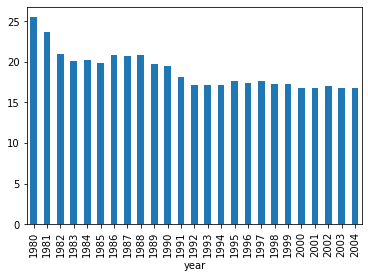

In [141]:
## Vendo como ela se comportou ao longo do tempo
taxa_fatalidade_ano = df.groupby('year')['totfatrte'].mean()
taxa_fatalidade_ano.plot(kind="bar")
print(taxa_fatalidade_ano)

# A média nacional caiu: houve menos mortes no trânsito por 100.000 habitantes

### Estruturando o Painel e Modelo Inicial

In [142]:
## Vendo grau de balancemaneto/desbalanceamento
df['aparicoes'] = df.groupby('state')['state'].transform('count')
df.drop_duplicates(subset=['state'], keep='first')['aparicoes'].value_counts(normalize=True)*100

# O painel é completamente balanceado, com todos os indivíduos sendo observados por 25 anos.
# (o que faz sentido, já que os dados são de estados e não indivíduos, que podem deixar de responder)

25    100.0
Name: aparicoes, dtype: float64

In [143]:
## Montando a estrutura do painel
df = df.set_index(["state", "year"], drop=False)

In [144]:
## Fazendo a mesma análise do gráfico usando MQO Agrupado
formula_ano = "totfatrte ~ 1 + C(year)"

# OLS Agrupado
modelo_ols_ano = PooledOLS.from_formula(formula=formula_ano, data=df).fit()
print(modelo_ols_ano.summary)

# Cada dummy possui um coeficiente menor que o do ano anterior (de modo geral)
# Como visto no gráfico, a taxa de fatalidade por 100.000 habitantes diminui ao longo do tempo
# A pergunta que fica é: por que?

                          PooledOLS Estimation Summary                          
Dep. Variable:              totfatrte   R-squared:                        0.1276
Estimator:                  PooledOLS   R-squared (Between):              0.0000
No. Observations:                1200   R-squared (Within):               0.5114
Date:                Fri, Oct 22 2021   R-squared (Overall):              0.1276
Time:                        18:43:05   Log-likelihood                   -3841.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      7.1639
Entities:                          48   P-value                           0.0000
Avg Obs:                       25.000   Distribution:                 F(24,1175)
Min Obs:                       25.000                                           
Max Obs:                       25.000   F-statistic (robust):             7.1639
                            

### Comparando Modelos

In [145]:
## Adicionando outros controles
formula = "totfatrte ~ 1+ C(year) + bac08 + bac10 + perse + sbprim + sbsecon + sl70plus + gdl + perc14_24 + unem + vehicmilespc"
# bac08 e bac10: limite máximo de álcool no sangue
# per se: revogação de licença imediatamente após crise de trânsito
# sbprim: oficiais de trânsito podem multar pessoas que não usem cinto de segurança (primary seatbelt law)
# sbsecon: oficiais de trânsito só podem multar a falta de cinto se houver algum outro motivo para parar o carro
# s170plus: limite de velocidade (speed limit) médio acima de 70 milhas por hora
# gdl: programa de supervisão de motoristas mais jovens
# perc14_24: percentagem da população entre 14 e 24 anos
# unem: taxa de desemprego
# vehicmilespc: número de milhas dirigidas por ano


# OLS Agrupado
modelo_ols = PooledOLS.from_formula(formula=formula, data=df).fit(cov_type="robust")  # controlando para heteroscedasticidade
print(modelo_ols.summary)

                          PooledOLS Estimation Summary                          
Dep. Variable:              totfatrte   R-squared:                        0.6078
Estimator:                  PooledOLS   R-squared (Between):              0.7063
No. Observations:                1200   R-squared (Within):               0.3116
Date:                Fri, Oct 22 2021   R-squared (Overall):              0.6078
Time:                        18:43:05   Log-likelihood                   -3362.1
Cov. Estimator:                Robust                                           
                                        F-statistic:                      53.096
Entities:                          48   P-value                           0.0000
Avg Obs:                       25.000   Distribution:                 F(34,1165)
Min Obs:                       25.000                                           
Max Obs:                       25.000   F-statistic (robust):             59.946
                            

- Efeitos temporais se intensificaram, o que mostra que as mortes podem estar concentrados em estados sem leis mais fortes
- Limite de álcool no sangue mais severo contribui para a queda nas mortes de trânsito (-2.49 a cada 100.000 mil habitantes), bem como leis *per se*, apesar de menos intencidade
- Cinto de segurança parece não ter efeito sobre a mortalidade (p-valor alto)
- Limites maiores de velocidade estão ligados a 3.34 mais mortes anuais no trânsito por 100.000 habitantes;
- Motoristas e população jovem não tem efeito sobre a taxa de fatalidade
- Mais desemprego contribui para mais mortes no trânsito (por que)?
- Milhas dirigidas não parece estar ligado a mais mortes (apesar ter p-valor 0, o valor da estimativa é muito diminuto)

In [146]:
## Regredindo por efeitos fixos
formula_ef = f"{formula} + EntityEffects"
modelo_ef = PanelOLS.from_formula(formula=formula_ef, data=df).fit(cov_type="robust")  # controlando para heteroscedasticidade

## Comparando os dois modelos
print("P-valores entre parênteses.")
print(compare(
    {'EF':modelo_ef, 
    'MQOA':modelo_ols}, 
    precision = 'pvalues').summary)

P-valores entre parênteses.
                    Model Comparison                   
                                     EF            MQOA
-------------------------------------------------------
Dep. Variable                 totfatrte       totfatrte
Estimator                      PanelOLS       PooledOLS
No. Observations                   1200            1200
Cov. Est.                        Robust          Robust
R-squared                        0.6262          0.6078
R-Squared (Within)               0.6262          0.3116
R-Squared (Between)              0.1866          0.7063
R-Squared (Overall)              0.2963          0.6078
F-statistic                      55.094          53.096
P-value (F-stat)                 0.0000          0.0000
=====================     =============   =============
Intercept                        19.523         -2.7161
                            (2.598e-14)        (0.3064)
C(year)[T.1981]                 -1.5111         -2.1755
                    

- Limites de álcool no sangue tem sua importância diminuída;
- Leis de cinto de segurança (primárias) diminuem a mortalidade
- Maiores limites de velocidade se tornam estatisticamente insignificantes
- Uma população mais jovem passa a ser marginalmente significante em explicar maiores taxas de fatalidade
- Desemprego passa a diminuir as mortes de trânsito e milhas dirigidas continuam tendo efeito diminuto

In [147]:
## Fazendo Efeitos Aleatórios e comparando as estimativas
modelo_ea = RandomEffects.from_formula(formula=formula, data=df).fit(cov_type="robust")  # controlando para heteroscedasticidade

## Comparando os dois modelos
print("P-valores entre parênteses.")
print(compare(
    {'EA':modelo_ea,
    'EF':modelo_ef, 
    'MQOA':modelo_ols}, 
    precision = 'pvalues').summary)

P-valores entre parênteses.
                             Model Comparison                            
                                       EA              EF            MQOA
-------------------------------------------------------------------------
Dep. Variable                   totfatrte       totfatrte       totfatrte
Estimator                   RandomEffects        PanelOLS       PooledOLS
No. Observations                     1200            1200            1200
Cov. Est.                          Robust          Robust          Robust
R-squared                          0.6178          0.6262          0.6078
R-Squared (Within)                 0.6260          0.6262          0.3116
R-Squared (Between)                0.2138          0.1866          0.7063
R-Squared (Overall)                0.3167          0.2963          0.6078
F-statistic                        55.381          55.094          53.096
P-value (F-stat)                   0.0000          0.0000          0.0000
==========

In [148]:
## As estimativas de EA parecem bem semelhantes às de EF: qual modelo é mais eficiente?
# Curiosidade: por ser calculado com uma quasi-média, EA SEMPRE SEMPRE SEMPRE estará entre as estimativas de MQOA e EF
# (quando todos os modelos estimarem as mesmas variáveis)

## Fazendo o teste de Hausman
# Variância Assintótica
var_assin = modelo_ef.cov - modelo_ea.cov

# Diferença entre os parâmetros
dif_parametros = modelo_ef.params - modelo_ea.params

# Calculando a estatística de Hausman
H = dif_parametros.dot(np.linalg.inv(var_assin)).dot(dif_parametros)

# Grau de Liberdade
graus_liberdade = modelo_ea.params.size - 1

# Calculando p-valor
# H0: não há correlação entre as variáveis independentes e as características não-observáveis
# Não-rejeitar H0: prefere-se EA, mas EF ainda é consisteente
# Rejeitar: prefere-se EF e EA é inconsistente
p = stats.chi2(graus_liberdade).sf(H)

print(p)

# As características não-observáveis NÃO são correlacionadas com as variáveis do modelo.
# Isso faz sentido, já que estamos tratando de estados e não pessoas
# Assim, prefere-se EA

0.9999999999999496


## 3. Efeito da concentração de mercado no preço de passagens áereas

O dataset contém dados de 4 anos (1997 a 2000), onde cada "indivíduo" é uma rota do mercado (Brasília - São Paulo, por exemplo).

In [149]:
## Lendo o dataset
# Descrição das variáveis: https://rdrr.io/cran/wooldridge/man/airfare.html
sArquivo = f"{sCaminho}airfare.dta"
df = pd.read_stata(sArquivo)

In [150]:
df.head()

,year,id,dist,passen,fare,bmktshr,ldist,y98,y99,y00,lfare,ldistsq,concen,lpassen
0,1997,1,528,152,106,0.8386,6.269096,0,0,0,4.663439,39.301571,0.8386,5.023880
1,1998,1,528,265,106,0.8133,6.269096,1,0,0,4.663439,39.301571,0.8133,5.579730
2,1999,1,528,336,113,0.8262,6.269096,0,1,0,4.727388,39.301571,0.8262,5.817111
3,2000,1,528,298,123,0.8612,6.269096,0,0,1,4.812184,39.301571,0.8612,5.697093
4,1997,2,861,282,104,0.5798,6.758094,0,0,0,4.644391,45.671837,0.5798,5.641907


In [151]:
# Vendo o tamanho da base
print(f"Linhas: {df.shape[0]}; Colunas: {df.shape[1]}")

Linhas: 4596; Colunas: 14


In [152]:
## Número de (rotas): 1.149
# Como há 4596 linhas e 1.149 indivíduos, já sabemos que o painel é totalmente balanceado (4596/1149 = 4)
df.groupby('id')['id'].count()

id
1       4
2       4
3       4
4       4
5       4
       ..
1145    4
1146    4
1147    4
1148    4
1149    4
Name: id, Length: 1149, dtype: int64

In [153]:
## Descrevendo o dataset
df.describe()

# dist: distancia da rota, em milhas
# passen: número médio de passageiros por dia
# fare: preço médio da passagem (só de ida)
# bmktshr=concen: fração do mercado da maior operadora da linha (biggest market share)
#   ^medida de concentração de mercado!

,year,id,dist,passen,fare,bmktshr,ldist,y98,y99,y00,lfare,ldistsq,concen,lpassen
count,4596.000000,4596.000000,4596.000000,4596.000000,4596.000000,4596.000000,4596.000000,4596.00000,4596.00000,4596.00000,4596.000000,4596.000000,4596.000000,4596.000000
mean,1998.500000,575.000000,989.744996,636.824195,178.796780,0.610116,6.696495,0.25000,0.25000,0.25000,5.095592,45.277554,0.610116,6.017019
std,1.118156,331.723694,611.831506,811.999966,74.881513,0.196435,0.659317,0.43306,0.43306,0.43306,0.436400,8.726903,0.196435,0.883986
min,1997.000000,1.000000,95.000000,2.000000,37.000000,0.160500,4.553877,0.00000,0.00000,0.00000,3.610918,20.737795,0.160500,0.693147
25%,1997.750000,288.000000,505.000000,215.000000,123.000000,0.465000,6.224558,0.00000,0.00000,0.00000,4.812184,38.745125,0.465000,5.370638
50%,1998.500000,575.000000,861.000000,357.000000,168.000000,0.603950,6.758094,0.00000,0.00000,0.00000,5.123964,45.671837,0.603950,5.877736
75%,1999.250000,862.000000,1304.000000,717.000000,225.000000,0.753100,7.173192,0.25000,0.25000,0.25000,5.416101,51.454678,0.753100,6.575076
max,2000.000000,1149.000000,2724.000000,8497.000000,522.000000,1.000000,7.909857,1.00000,1.00000,1.00000,6.257668,62.565834,1.000000,9.047468


year
1997    173.751958
1998    175.441253
1999    177.970409
2000    188.023499
Name: fare, dtype: float64


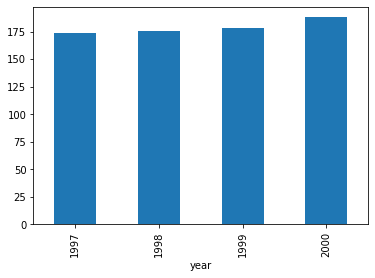

In [154]:
## Vendo como a tarifa média se comportou ao longo do tempo
tarifa_ano = df.groupby('year')['fare'].mean()
tarifa_ano.plot(kind="bar")
print(tarifa_ano)

### Painel e Análise

In [155]:
## Montando a estrutura do painel
df = df.set_index(["id", "year"], drop=False)

In [156]:
## O que pode determinar o aumento de preço por ano?
## Modelo MQOA
formula = "lfare ~ 1 + concen + ldist + ldistsq + C(year)"

modelo_ols = PooledOLS.from_formula(formula=formula, data=df).fit(cov_type="robust")
print(modelo_ols.summary)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lfare   R-squared:                        0.4062
Estimator:                  PooledOLS   R-squared (Between):              0.4215
No. Observations:                4596   R-squared (Within):               0.1246
Date:                Fri, Oct 22 2021   R-squared (Overall):              0.4062
Time:                        18:43:06   Log-likelihood                   -1512.3
Cov. Estimator:                Robust                                           
                                        F-statistic:                      523.18
Entities:                        1149   P-value                           0.0000
Avg Obs:                       4.0000   Distribution:                  F(6,4589)
Min Obs:                       4.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             558.39
                            

- Um aumento de 10% na concentração de mercado aumenta em 3,6% o preço médio de uma rota;
- O preço da passagem cresce de forma exponencial com a distância (mesmo comportamento de educação nas equações de salário).
Note que o efeito combinado de *ldist* só é menor que 0 quando *ldist* < 4.35 (0,1030*ldist* < 0,9016*ldistsq*) e, consequentemente, *ldist* < 80. O menor valor de distância no dataset é de 95 milhas, ou seja, sempre a distância contribui positivamente para o preço no *range* dos nossos dados.

**Detalhe téorico**: como *ldist* e *lfare* estão em log, diz-se que os coeficientes de *ldist* são as **elasticidades** e dizem a variação percentual do preço para uma variação de 1% na distância.

Como usamos termos quadráticos, permitimos que essa elasticidade seja variável: nossas estimativas indicam que, quanto maior a distância, um incremento adicional de 1% leva a um aumento maior no preço do que em menores distâncias (o que faz sentido: 1% de 200 milhas é maior que 1% de 100 milhas e os custos de linhas aéreas costumam ser calculados por milhas (ou quilômetros) no ar).

De forma similar, como *concen* é uma taxa percentual, ela também é a **elasticidade do preço com relação a concentração de mercado**: seu coeficiente mostra, para uma variação de 1% na concentração, qual será a variação do preço

### Comparando modelos

In [157]:
## Comparando modelos
## Definindo a fórmula
formula_ef = f"{formula} + EntityEffects"

## Criando os três modelos
# Efeitos Fixos (não estimam a distância porque ela é fixa para uma dada rota)
modelo_ef = PanelOLS.from_formula(formula=formula_ef, data=df, drop_absorbed=True)
modelo_ef = modelo_ef.fit(cov_type='robust')

# Efeitos Aleatórios
modelo_ea = RandomEffects.from_formula(formula=formula, data=df).fit(cov_type='robust')

/usr/local/lib/python3.7/dist-packages/linearmodels/panel/model.py:1798: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

ldist, ldistsq

  AbsorbingEffectWarning,


In [158]:
## Vendo os resultados
print("P-valores entre parênteses.")
print(compare(
    {'EF':modelo_ef, 
     'EA':modelo_ea,
     'MQOA':modelo_ols}, 
     precision = 'pvalues').summary)

P-valores entre parênteses.
                             Model Comparison                            
                                     EF                EA            MQOA
-------------------------------------------------------------------------
Dep. Variable                     lfare             lfare           lfare
Estimator                      PanelOLS     RandomEffects       PooledOLS
No. Observations                   4596              4596            4596
Cov. Est.                        Robust            Robust          Robust
R-squared                        0.1352            0.2285          0.4062
R-Squared (Within)               0.1352            0.1348          0.1246
R-Squared (Between)             -0.0417            0.4175          0.4215
R-Squared (Overall)             -0.0325            0.4029          0.4062
F-statistic                      134.61            226.57          523.18
P-value (F-stat)                 0.0000            0.0000          0.0000
==========

Apesar de menor, as estimativas para o efeito da concentração de EF e EA (que retiram particularidades não-observadas de cada rota) ainda são bastante altas e significativas: há distorção de oligopólio/monopólio em qualquer um dos modelos.

In [159]:
## Por fim, teste de Hausman
# Modelo EA sem ldist e ldistsq
formula_ea = "lfare ~ 1 + concen + C(year)"
modelo_ea_ldist = RandomEffects.from_formula(formula=formula_ea, data=df).fit(cov_type='robust')

# Variância Assintótica
var_assin = modelo_ef.cov - modelo_ea_ldist.cov

# Diferença entre os parâmetros
dif_parametros = modelo_ef.params - modelo_ea_ldist.params

# Calculando a estatística de Hausman
H = dif_parametros.dot(np.linalg.inv(var_assin)).dot(dif_parametros)

# Grau de Liberdade
graus_liberdade = modelo_ea_ldist.params.size - 1

# Calculando p-valor
# H0: não há correlação entre as variáveis independentes e as características não-observáveis
# Não-rejeitar H0: prefere-se EA, mas EF ainda é consisteente
# Rejeitar: prefere-se EF e EA é inconsistente
p = stats.chi2(graus_liberdade).sf(H)

print(p)

# As características não-observáveis NÃO são correlacionadas com as variáveis do modelo
# Assim, prefere-se EA e estimativa mais precisa da elasticidade da concentração é ≈ 0,2

0.21096321270198504


# Bom sábado a todos!